In [1]:
!nvidia-smi

Fri May 28 10:26:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq pytorch-lightning
!pip install -qq torchinfo

     |████████████████████████████████| 808kB 2.8MB/s 
     |████████████████████████████████| 645kB 16.8MB/s 
     |████████████████████████████████| 112kB 17.1MB/s 
     |████████████████████████████████| 829kB 17.7MB/s 
     |████████████████████████████████| 276kB 19.1MB/s 
     |████████████████████████████████| 10.6MB 19.5MB/s 
     |████████████████████████████████| 1.3MB 48.7MB/s 
     |████████████████████████████████| 296kB 50.4MB/s 
     |████████████████████████████████| 143kB 31.5MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl

from tqdm import tqdm
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Iterable, Callable, Dict

In [4]:
BS = 64

IMG_SZ = 32
IMG_CHANNELS = 3
NUM_CLASSES = 10

NUM_PATCHES = 16
NUM_CHANNELS = 512

DEPTH = 20
EPOCHS = 40
EXPANSION = 8
DROPOUT = 0.4

# Data

In [5]:
train_dl = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        "./data/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [   
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=BS,
    shuffle=True,
    num_workers=os.cpu_count(),
)

val_dl = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        "./data/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=BS,
    num_workers=os.cpu_count(),
)



Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


# MLP Mixer

In [6]:
class MLP(nn.Module):
    def __init__(self, dim, expansion, dropout):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(dim, dim * expansion)
        self.act = nn.GELU()
        self.lin2 = nn.Linear(dim * expansion, dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.lin1(x)
        x = self.act(x)
        x = self.drop(x)
        
        x = self.lin2(x)
        x = self.drop(x)

        return x

In [7]:
class MixerLayer(nn.Module):
    def __init__(self, num_patches, num_channels, expansion, dropout):
        super(MixerLayer, self).__init__()
        self.norm1 = nn.LayerNorm(num_channels)
        self.by_patch = MLP(num_patches, expansion, dropout)
        self.by_channel = MLP(num_channels, expansion, dropout)
        self.norm2 = nn.LayerNorm(num_channels)

    def forward(self, x):
        # x.shape -> B, P, C
        identity = x
        x = self.norm1(x)

        # x.shape -> B, C, P
        x = self.by_patch(torch.transpose(x, 1, 2))

        # x.shape -> B, P, C
        x = torch.transpose(x, 1, 2) + identity

        # x.shape -> B, P, C
        identity = x
        x = self.norm2(x)
        x = self.by_channel(x) + identity

        return x

In [8]:
class MLPMixer(pl.LightningModule):
    def __init__(
        self,
        img_sz,
        img_channels,
        num_classes,
        depth,
        num_patches,
        num_channels,
        expansion,
        dropout,
        lr=2e-4
    ):
        super(MLPMixer, self).__init__()
        self.lr = lr
        self.img_sz = img_sz
        self.img_channels = img_channels

        self.num_patches = num_patches
        self.num_channels = num_channels

        self.patch_sz = int(((self.img_sz ** 2) // self.num_patches) ** (1 / 2))

        inp_channels = ((img_sz ** 2) // num_patches) * img_channels

        self.per_patch = nn.Linear(inp_channels, num_channels)

        self.mixer_layers = nn.ModuleList(
            [MixerLayer(num_patches, num_channels, expansion, dropout) for _ in range(depth)]
        )

        self.identity = nn.Identity()
        self.classifier = nn.Linear(num_channels, num_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        bs = x.shape[0]

        # creating patches of the images
        x = (
            x.data.unfold(1, self.img_channels, self.img_channels)
            .unfold(2, self.patch_sz, self.patch_sz)
            .unfold(3, self.patch_sz, self.patch_sz)
        )

        x = x.reshape(bs, -1, self.img_channels * self.patch_sz * self.patch_sz)

        # per patch fc
        x = self.per_patch(x)

        # mixer layers
        for layer in self.mixer_layers:
            x = layer(x)

        # classifier
        x = x.mean(1)
        x = self.identity(x) # for feature extraction
        return self.classifier(x)

    def training_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        return self.loss(out, labels)

    def validation_step(self, xb, batch_idx):
        inp, labels = xb
        out = self(inp)

        labels_hat = torch.argmax(out, dim=1)
        val_acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)

        self.log(
            "val_loss",
            self.loss(out, labels),
            prog_bar=True,
            on_step=False,
            on_epoch=True,
        )
        self.log("val_acc", val_acc, prog_bar=True, on_step=False, on_epoch=True)

        return val_acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Evaluation

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output

        return fn

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        _ = self.model(x)
        return self._features

In [10]:
@torch.no_grad()
def eval(model, val_dl):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = model.eval()

    model = FeatureExtractor(model, ["identity"]).to(device)

    ys = []
    outs = []
    for x, y in tqdm(val_dl):
        out = model(x.to(device)).get("identity").detach()
        outs.append(out.reshape(x.shape[0], -1))
        ys.append(y)

    outs = torch.cat(outs, dim=0).cpu()
    ys = torch.cat(ys, dim=0).cpu()

    decomposer = PCA(n_components=3)
    decomposed = decomposer.fit_transform(outs.numpy())

    colors = {
        1: "blue",
        2: "orange",
        3: "green",
        4: "red",
        5: "purple",
        6: "brown",
        7: "pink",
        8: "gray",
        9: "olive",
        0: "cyan",
    }

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    ax.scatter(
        xs=decomposed[:, 0],
        ys=decomposed[:, 1],
        zs=decomposed[:, 2],
        c=list(map(lambda x: colors[int(x)], list(ys))),
    )
    plt.show()

# Execution

In [11]:
model = MLPMixer(
    IMG_SZ,
    img_channels=IMG_CHANNELS,
    num_classes=NUM_CLASSES,
    depth=DEPTH,
    num_patches=NUM_PATCHES,
    num_channels=NUM_CHANNELS,
    expansion=EXPANSION,
    dropout=DROPOUT,
)

print(summary(model, input_size=(1, IMG_CHANNELS, IMG_SZ, IMG_SZ)))

Layer (type:depth-idx)                   Output Shape              Param #
MLPMixer                                 --                        --
├─Linear: 1-1                            [1, 16, 512]              98,816
├─ModuleList: 1                          --                        --
│    └─MixerLayer: 2-1                   [1, 16, 512]              --
│    │    └─LayerNorm: 3-1               [1, 16, 512]              1,024
│    │    └─MLP: 3-2                     [1, 512, 16]              4,240
│    │    └─LayerNorm: 3-3               [1, 16, 512]              1,024
│    │    └─MLP: 3-4                     [1, 16, 512]              4,198,912
│    └─MixerLayer: 2-2                   [1, 16, 512]              --
│    │    └─LayerNorm: 3-5               [1, 16, 512]              1,024
│    │    └─MLP: 3-6                     [1, 512, 16]              4,240
│    │    └─LayerNorm: 3-7               [1, 16, 512]              1,024
│    │    └─MLP: 3-8                     [1, 16, 512]   

In [12]:
trainer = pl.Trainer(
    default_root_dir="logs",
    gpus=(1 if torch.cuda.is_available() else 0),
    max_epochs=EPOCHS,
    logger=pl.loggers.TensorBoardLogger("logs/", name="mlp_mixer_cifar_10", version=0),
    precision=16,
)

trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | per_patch    | Linear           | 98.8 K
1 | mixer_layers | ModuleList       | 84.1 M
2 | identity     | Identity         | 0     
3 | classifier   | Linear           | 5.1 K 
4 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
84.2 M    Trainable params
0         Non-trainable params
84.2 M    Total params
336.832   Total estimated model params size (MB)


In [13]:
model = model.cuda().eval()
ys = []
outs = []

with torch.no_grad():
    for x, y in tqdm(val_dl):
        out = model(x.cuda()).detach()
        outs.append(out.reshape(x.shape[0], -1))
        ys.append(y)

outs = torch.cat(outs, dim=0).cpu()
labels = torch.cat(ys, dim=0).cpu()

labels_hat = torch.argmax(outs, dim=1)
val_acc = torch.sum(labels == labels_hat).item() / (len(labels) * 1.0)

print("\nValidation Accuracy: ", round(100*val_acc, 4))

100%|██████████| 157/157 [00:03<00:00, 43.39it/s]


Validation Accuracy:  70.36


100%|██████████| 157/157 [00:03<00:00, 42.75it/s]


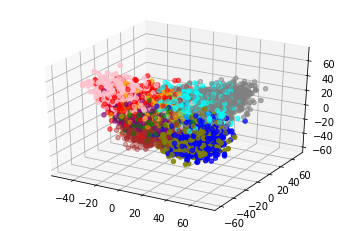

In [14]:
eval(model, val_dl)